In [1]:
!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("dataset_binary.csv")

print("Shape:", df.shape)
print("\nTarget Distribution:\n", df["Diabetes_binary"].value_counts())
df.head()

Shape: (253680, 22)

Target Distribution:
 Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df = df.drop(columns=["Stroke", "HeartDiseaseorAttack"], errors='ignore')
df.drop_duplicates(inplace=True)

X = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_sm))

After SMOTE: [154380 154380]


In [8]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

lr.fit(X_train_sm, y_train_sm)

y_probs = lr.predict_proba(X_test)[:, 1]

In [9]:
# Threshold Tuning (F1-based)
def find_best_threshold(y_true, y_probs):
    best_t = 0
    best_f1 = 0

    for t in np.arange(0.1, 0.9, 0.02):
        y_pred = (y_probs > t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t

best_threshold = find_best_threshold(y_test, y_probs)

print("Best Threshold:", best_threshold)

Best Threshold: 0.5800000000000001


In [10]:
y_pred = (y_probs > best_threshold).astype(int)

In [11]:
print("\nLogistic Regression (Final)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression (Final)
Accuracy: 0.7651393854319742
Precision: 0.35572661534872874
Recall: 0.653851650707446
F1: 0.46077147749018027
AUC: 0.8068372798623125
Confusion Matrix:
 [[30310  8286]
 [ 2422  4575]]


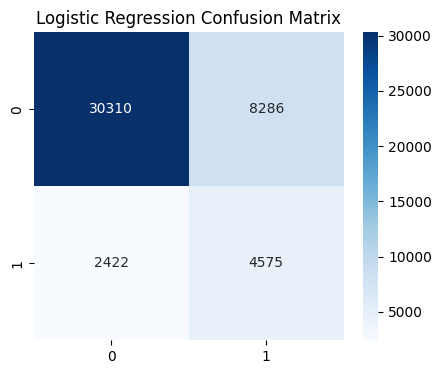

In [12]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

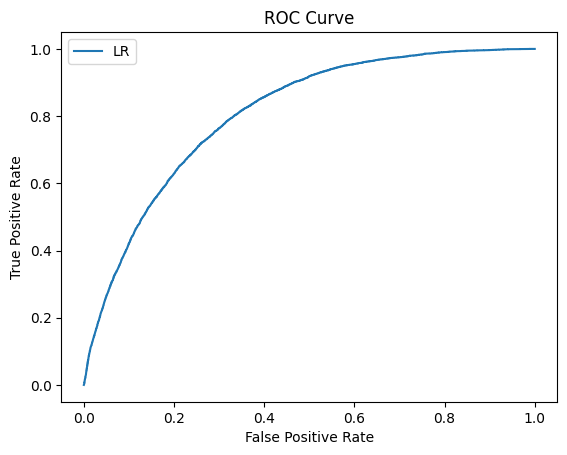

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label="LR")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

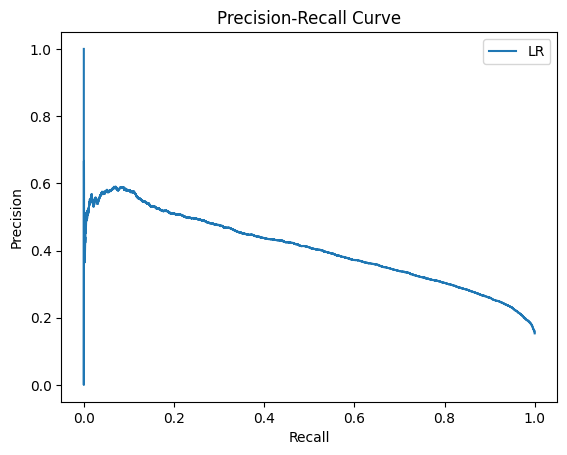

In [14]:
p, r, _ = precision_recall_curve(y_test, y_probs)

plt.plot(r, p, label="LR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()